In [1]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt

### DOWNLOAD THE HOUSNIG DATA

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "data.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    print('download is finished')

In [3]:
fetch_housing_data()

download is finished


### READING THE HOUSING DATA

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing_df = load_housing_data()

In [6]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


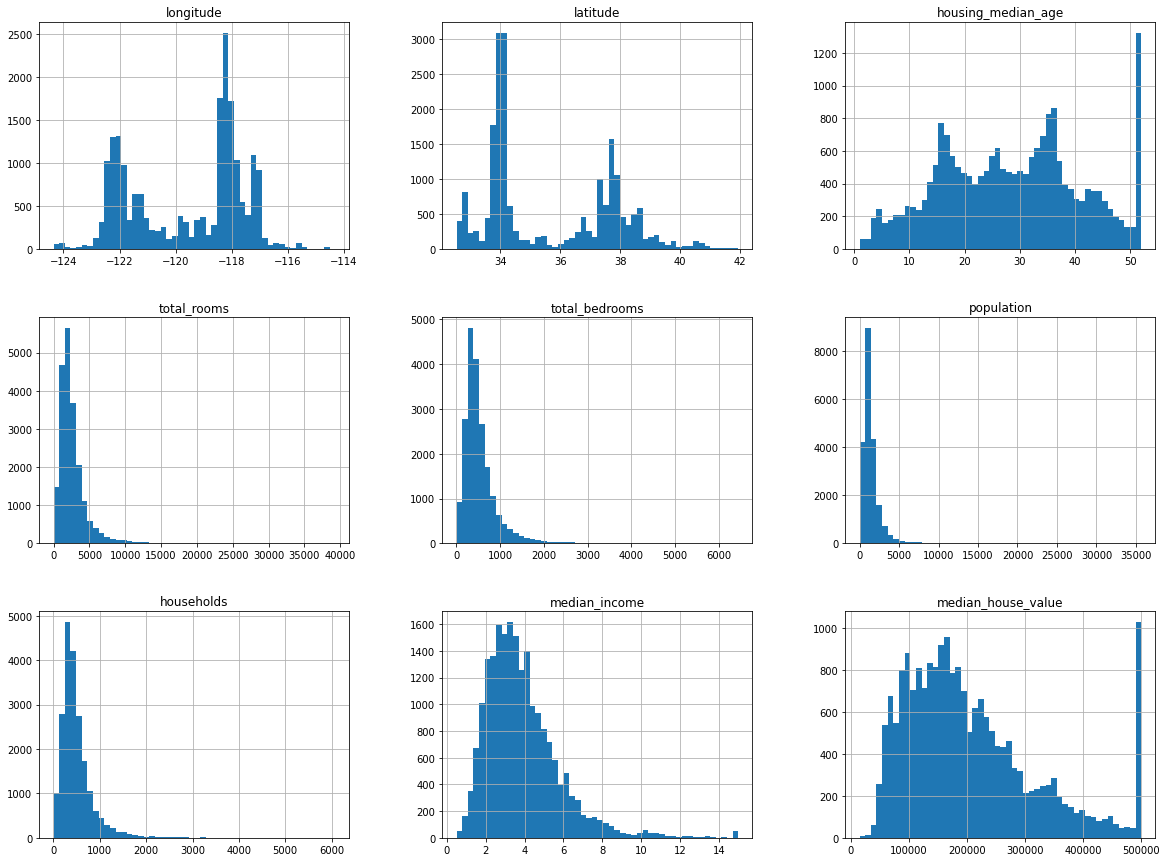

In [10]:
housing_df.hist(bins=50,figsize=(20,15))
plt.show()

### SPLIT THE DATASET (training set,test set)

In [11]:
"""
    good solutionbut its not perfect, each time we rerun the program we will generate diffent sets.
    a solution is to store the sets in a csv after the first run.
"""
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices],data.iloc[test_indices]
    

In [12]:
train_set, test_set = split_train_test(housing_df, 0.2)

In [13]:
len(train_set)

16512

In [14]:
len(test_set)

4128

### TURN A CONTINOUS VARIABLE INTO CATEGORICAL VARIABLE

In [100]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1,2,3,4,5])

<AxesSubplot: >

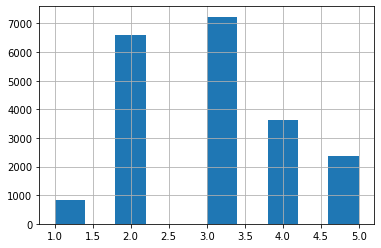

In [101]:
housing_df["income_cat"].hist()

### SPLIT THE DATASET USING SCICKIT LEARN

In [102]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [103]:
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [104]:
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.iloc[train_index]
    strat_test_set = housing_df.iloc[test_index]

In [105]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set["income_cat"])

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [21]:
train_index

array([12655, 15502,  2908, ..., 19263, 19140, 19773], dtype=int64)

In [22]:
strat_test_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.000000,4128.000000,4128.000000,4128.000000,4079.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.545981,35.602049,28.583818,2688.656250,549.721746,1448.634205,509.651163,3.849818,206257.795058
std,2.010400,2.127889,12.629796,2345.997876,454.528621,1197.164964,407.677609,1.879332,114176.653346
min,-124.180000,32.550000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.920000,18.000000,1474.000000,301.000000,805.750000,283.000000,2.542675,118900.000000
50%,-118.460000,34.220000,28.000000,2159.500000,442.000000,1172.500000,416.000000,3.513200,181300.000000
75%,-117.980000,37.690000,37.000000,3171.250000,653.000000,1754.250000,613.250000,4.739225,268850.000000
max,-114.560000,41.950000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [23]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [106]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

C:\Users\oussa\AppData\Local\Temp\ipykernel_11240\1299016719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
C:\Users\oussa\AppData\Local\Temp\ipykernel_11240\1299016719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [25]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


### Discover and Visualize the Data to Gain Insights

In [26]:
housing = strat_train_set.copy()

In [27]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


C:\Users\oussa\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

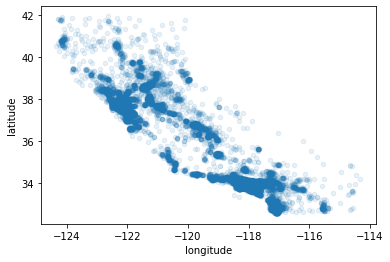

In [28]:
housing.plot(kind="scatter",x="longitude",y="latitude",xlabel='longitude', ylabel='latitude',alpha=0.1)

In [29]:
housing["population"].head()

12655    2237.0
15502    2015.0
2908      667.0
14053     898.0
20496    1837.0
Name: population, dtype: float64

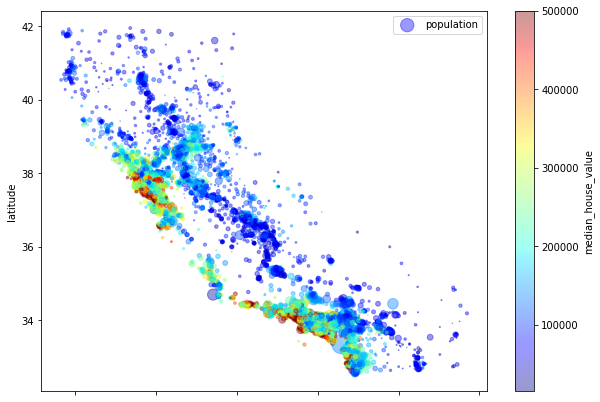

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,s=housing["population"]/100, label="population", figsize=(10,7),c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

### correlation between the attributes

In [31]:
corr_matrix = housing.corr()

In [32]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_income', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel='med

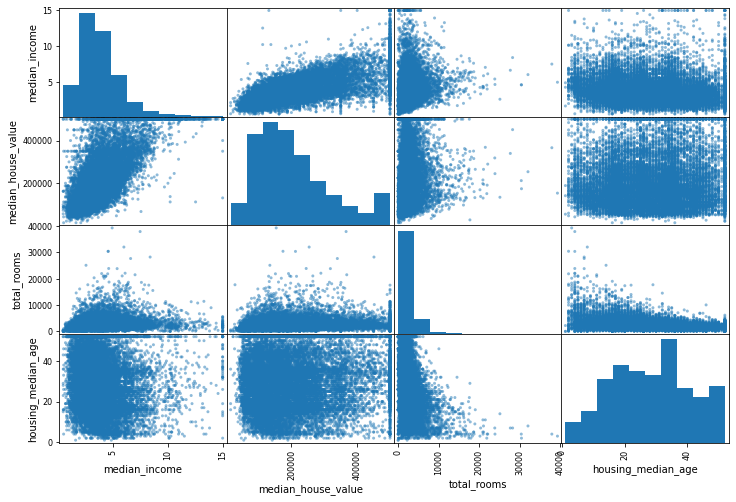

In [34]:
attributes = ["median_income","median_house_value","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12, 8))

C:\Users\oussa\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


'\n    the correlation between median income and median house value are very strong,\n'

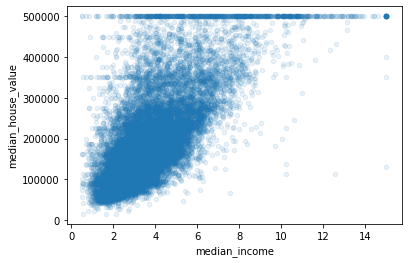

In [35]:
# we can extract a pattern using these plots
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1,xlabel='median_income', ylabel='median_house_value')
"""
    the correlation between median income and median house value are very strong,
"""

### creating new attributes

In [36]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [37]:
corr_matrix = housing.corr()

In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithm

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [108]:
### fill the na values with median of the column

In [109]:
imputer = SimpleImputer(strategy="median")

In [41]:
"""
    ocean proximity is a categorical variable so we cannot calculate it's median
"""
housing_num = housing.drop("ocean_proximity",axis=1)

In [42]:
"""
    Since the median can only be computed on numerical attributes, you need to create a
    copy of the data without the text attribute ocean_proximity
"""
housing_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [43]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [45]:
housing_num.median()

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [46]:
x = imputer.transform(housing_num)

In [47]:
x

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [48]:
housing_tr = pd.DataFrame(x,columns=housing_num.columns,index=housing_num.index)

In [49]:
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [50]:
df = np.c_[housing_tr,housing_tr["latitude"]]
columns = housing_tr.columns
columns = list(columns)
columns.append("last")
df = pd.DataFrame(df,columns=columns,index=housing_tr.index)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,last
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,38.52
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,33.09
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,35.37
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,32.75
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,34.28
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,33.03
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,38.51
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,38.44
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,38.31


In [51]:
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [52]:
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [53]:
onehot_encoder = OneHotEncoder()

In [54]:
housing_cat_1hot = onehot_encoder.fit_transform(housing[["ocean_proximity"]])

In [55]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [56]:
rooms_idx,bedroom_idx,population_idx,households_idx = 3,4,5,6
class combinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = True
        
    def fit(self,X,Y=None):
        return self
    
    def transform(self,X):
        rooms_per_household = X[:,rooms_idx] / X[:,households_idx]
        population_per_household = X[:,population_idx] / X[:,households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedroom_idx] / X[:,rooms_idx]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        return np.c_[X,rooms_per_household,population_per_household]
        
        
        

In [57]:
attr_adder = combinedAttributesAdder(add_bedrooms_per_room = False)

In [58]:
housing_attr_extra = attr_adder.transform(housing_tr.values)

In [59]:
housing_attr_extra

array([[-121.46      ,   38.52      ,   29.        , ...,    5.48583569,
           3.16855524,    0.20578363],
       [-117.23      ,   33.09      ,    7.        , ...,    6.92708333,
           2.62369792,    0.16071429],
       [-119.04      ,   35.37      ,   44.        , ...,    5.39333333,
           2.22333333,    0.19159456],
       ...,
       [-122.72      ,   38.44      ,   48.        , ...,    4.11046512,
           2.6627907 ,    0.23479491],
       [-122.7       ,   38.31      ,   14.        , ...,    6.29740519,
           2.41117764,    0.18383518],
       [-122.14      ,   39.97      ,   27.        , ...,    5.47715736,
           3.17258883,    0.20574606]])

In [60]:
# combine multiple transoformers
pipeline_num = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ("attrs_adder",combinedAttributesAdder(add_bedrooms_per_room = False)),
    ("std_scaler",StandardScaler())
])

In [61]:
pipeline_num.fit_transform(housing_num)

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [62]:
list(housing_num)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [63]:
# one transformeer for nemurical and categorical features
num_attributs = list(housing_num)
cat_attributs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num",pipeline_num,num_attributs),
    ("cat",OneHotEncoder(),cat_attributs)
])

In [64]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

### Training and Evaluating on the Training Set

### 1 - Linear regression

In [65]:
# using Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [66]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predicted = lin_reg.predict(some_data_prepared)
print("predictions",list(predicted))
print("labels",list(some_labels))

predictions [85657.90192014407, 305492.6073748765, 152056.46122455693, 186095.7094609436, 244550.6796608895]
labels [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [67]:
# start evaluating Linear regression
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_predictions,housing_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

### 2- Decision tree

In [68]:
dec_reg = DecisionTreeRegressor()
dec_reg.fit(housing_prepared,housing_labels)
some_data_prepared = full_pipeline.transform(some_data)
predicted = dec_reg.predict(some_data_prepared)
print("predictions",list(predicted))
print("labels",list(some_labels))

predictions [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]
labels [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [69]:
# start evaluating decision tree regresion
housing_predictions = dec_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_predictions,housing_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

### Evaluation Using Cross-Validation

In [70]:
scores = cross_val_score(dec_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([72188.79567905, 69575.2421232 , 68743.91913455, 71899.61700722,
       70933.19907396, 78191.30089163, 69914.6533534 , 74040.16618295,
       68958.81809818, 71411.60917987])

In [71]:
def display_score(score):
    print("score : ",score)
    print("mean : ",score.mean())
    print("std :",score.std())

In [72]:
display_score(tree_rmse_scores)

score :  [72188.79567905 69575.2421232  68743.91913455 71899.61700722
 70933.19907396 78191.30089163 69914.6533534  74040.16618295
 68958.81809818 71411.60917987]
mean :  71585.73207240159
std : 2690.4881622677203


In [73]:
scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
lin_rmse_scores

array([71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082,
       66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334,
       66443.28836884, 70139.79923956])

In [74]:
display_score(lin_rmse_scores)

score :  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
mean :  69104.07998247063
std : 2880.3282098180666


In [75]:
###  the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model

In [76]:
### trying random forst regressor
### is a combination of multiple Tree decisions
"""
    Random Forests work by training many Decision Trees on random subsets of
    the features, then averaging out their predictions. Building a model on top of many
    other models is called Ensemble Learning, and it is often a great way to push ML algo‐
    rithms even further.
"""

rfr_reg = RandomForestRegressor()
rfr_reg.fit(housing_prepared,housing_labels)
housing_predictions = rfr_reg.predict(housing_prepared)

In [77]:
mse = mean_squared_error(housing_predictions,housing_labels)

In [78]:
rmse = np.sqrt(mse)
rmse

18784.608784684402

### export and import models

In [79]:
#exprort
joblib.dump(rfr_reg,"rfr_model.pkl")

['rfr_model.pkl']

In [80]:
rfr_loaded=joblib.load("./rfr_model.pkl")

In [81]:
rfr_loaded.predict([housing_prepared[1]])

array([294778.])

In [82]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [83]:
rfr_reg = RandomForestRegressor()
grid_search = GridSearchCV(rfr_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

In [84]:
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
grid_search.predict(housing_prepared)

array([ 73473.33333333, 284990.        ,  79066.66666667, ...,
       159130.        , 252440.        ,  75106.66666667])

In [86]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [87]:
print(grid_search.best_estimator_)

RandomForestRegressor(max_features=6, n_estimators=30)


In [88]:
cv_results = grid_search.cv_results_

In [89]:
cv_results["mean_test_score"]
#cv_results["params"]
for score,params in zip(cv_results["mean_test_score"],cv_results["params"]):
    print(np.sqrt(-score), params)

63869.93420205127 {'max_features': 2, 'n_estimators': 3}
55353.61305622208 {'max_features': 2, 'n_estimators': 10}
52815.74464013881 {'max_features': 2, 'n_estimators': 30}
60735.2270471633 {'max_features': 4, 'n_estimators': 3}
52954.31521241492 {'max_features': 4, 'n_estimators': 10}
50413.04564776352 {'max_features': 4, 'n_estimators': 30}
59353.13087614896 {'max_features': 6, 'n_estimators': 3}
52173.53534695697 {'max_features': 6, 'n_estimators': 10}
49739.60634678487 {'max_features': 6, 'n_estimators': 30}
59462.22679448378 {'max_features': 8, 'n_estimators': 3}
52391.56873730564 {'max_features': 8, 'n_estimators': 10}
50108.51146008299 {'max_features': 8, 'n_estimators': 30}
62520.05958740958 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54042.92087093418 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59242.62837350341 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52854.29293414429 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [90]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [91]:
num_attributs
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
categories = list(cat_encoder.categories_[0])
attributes = num_attributs + extra_attribs+categories

In [92]:
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [93]:
sorted(list(zip(feature_importances,attributes)),reverse=True)

[(0.31388818748383013, 'median_income'),
 (0.1540428503847937, 'INLAND'),
 (0.11324770098716724, 'pop_per_hhold'),
 (0.09223623035891211, 'bedrooms_per_room'),
 (0.06879183138720749, 'longitude'),
 (0.06802467709822801, 'latitude'),
 (0.054914655898384644, 'rooms_per_hhold'),
 (0.04294293687335081, 'housing_median_age'),
 (0.017941376662967957, 'total_rooms'),
 (0.017791333694199798, 'population'),
 (0.016715707983135146, 'total_bedrooms'),
 (0.01653554998367684, 'households'),
 (0.012404337667198175, '<1H OCEAN'),
 (0.005508530273185099, 'NEAR OCEAN'),
 (0.004956766092137232, 'NEAR BAY'),
 (5.732717162558922e-05, 'ISLAND')]